In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

PassengerId = test['PassengerId']

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,23,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,51,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,44,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,24,0


In [7]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] =1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std,
                                             age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)


In [8]:
train['CategoricalAge'] = pd.cut(train['Age'], 5)    


In [9]:


def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)





In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",Mr


In [11]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt',\
                                                'Col', 'Dr','Major', 'Rev', 'Sir',\
                                                'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace("Mlle", 'Miss')
    dataset['Title'] = dataset['Title'].replace("Ms", "Miss")
    dataset['Title'] = dataset['Title'].replace("Mme", 'Mrs')




In [12]:
for  dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master": 4, "Rare":5}

    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title']= dataset['Title'].fillna(0)

    dataset["Embarked"] = dataset['Embarked'].map({"S":0, "C":1, "Q":2}).astype(int)

    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ (dataset['Fare'] > 31) , 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] =1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] =2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] =3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [13]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3.0
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3.0
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1.0


In [14]:
drop_elements = ['PassengerId','Name','Ticket','Cabin','SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)



<AxesSubplot:title={'center':'Person Correlation of Feaure'}>

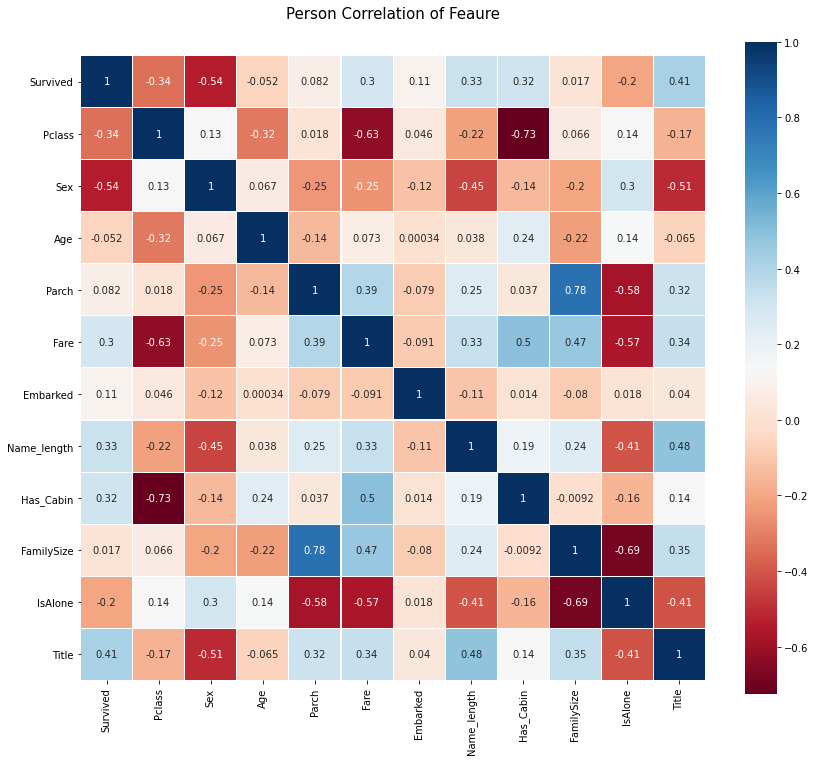

In [15]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Feaure', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor="white", annot=True)




In [18]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_splits=NFOLDS, random_state=SEED)

class SklernHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)





In [19]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)


In [28]:

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}


et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf':2,
    'verbose': 0
}

svc_params = {
    'kernel': 'linear',
    'C': 0.025
}



In [29]:
rf = SklernHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklernHelper(clf=ExtraTreesClassifier, seed = SEED, params=et_params)
ada = SklernHelper(clf=AdaBoostClassifier,seed= SEED, params= ada_params)
gb = SklernHelper(clf=GradientBoostingClassifier, seed=SEED, params= gb_params)
svv = SklernHelper(clf=SVC, seed=SEED, params= svc_params)


In [30]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values


In [31]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)


TypeError: 'KFold' object is not iterable